# Как я учил английский

В какой-то момент я осознал что мне необходимо расширить свой лексикон английских слов.  
Самая большая сложность как выяснилось в процессе - это овладеть первыми 300-500 словами.  

В этом ноутбуке я разобрал результаты того как проходила часть моего обучения до тысячи слов.  
Мне было интересно написать самому тест с помощью которого я смог бы расширить свой лексикон.  
http://ayumu.ru/ здесь каждый желающий может проделать тот же путь что и я.  

выглядит это так:  

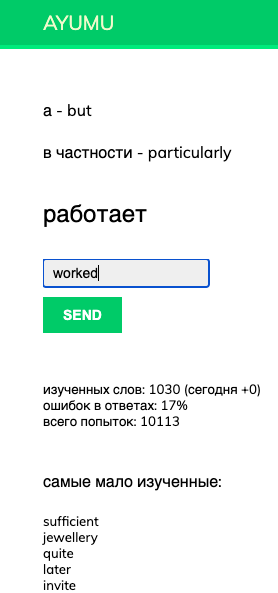

- вам выдаются по очереди слова, нужно вписать ответ и нажать enter
- выдаётся следущее слово
- если ответ не правильный - высвечивается подсказка с правильным ответом
- начинаем с самых высокочастотных слов, и постепенно берём всё более редкие
- в процессе обучения чаще работаем с теми словами, которые плохо запоминаются пока их не выучим
- чередуем тренировки русско-английский и англо-русский словари блоками по несколько слов
- остановится можно в любой момент, следующая тренировка начнется с того места где вы остановились
- в базе 5000 английских слов

При изучении языка чаще всего проподает мотивация продолжать, пока ты не знаешь минимума объёма слов - крайне трудно улавливать суть текста на английском который читаешь из-за того что к окончанию предложения ты уже забываешь что было в начале. Но если усердно тренироваться это не займёт много времени, и уже после заветных 500 слов ты начнешь уверенно понимать что написано.

<hr>

Отступление:  
Лучший способ увлечь себя - это читать книги на английском в ридере со встроеным переводчиком (я пользовался https://smart-book.net/), это сильно мотивирует практиковать язык.  
При объёме лексикона в 1000 слов принципиально меняется восприятие языка, и здесь уже совсем не обойтись без тренировки построения предложений (мне понравился https://polyglotmobile.ru/polyglot-english-base/), там же можно практиковать произношение предложений.  
Последний этап это скоростное восприятие на слух, и здесь лучше всего подходят вильмы с английскими субтитрами.

<hr>

Через какое-то время мне стало любопытно как идёт обучение, есть ли сложности или когда ухудшаются показатели, сколько времени в цифрах и графиках оно фактически занимает.

In [9]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import time
from datetime import datetime, timedelta

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (12,5)})

In [10]:
# подключение к БД
def create_connection(path):
    """подключение к БД"""
    connection = None
    try:
        connection = sqlite3.connect(path)
        #print("Connection SQLite DB successful.")
    except Error as e:
        print(f"The error '{e}' occurred.")
    return connection

# создаем соединение с БД
def exec_fetch(query, values={}):
    """извлечение из БД"""
    connection = create_connection("db.sqlite3")
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query, values)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred.")

In [12]:
# так выглядит таблица результатов тренировок
# username_id = 37 это данные о моих тренировках
data = exec_fetch("SELECT * FROM training_result WHERE username_id = 37")
columns = ['id', 'answer', 'question', 'status', 'datetime', 'username_id', 'test_type']
tr = pd.DataFrame(data, columns=columns)
tr['datetime'] = pd.to_datetime(tr.datetime)
tr

,id,answer,question,status,datetime,username_id,test_type
0,1,быть,be,1,2022-06-01 04:30:27.174756,37,ER
1,2,быть,be,1,2022-06-01 04:30:35.067386,37,ER
2,3,в,in,1,2022-06-01 04:30:37.991171,37,ER
3,4,и,and,1,2022-06-01 04:30:40.045528,37,ER
4,5,из,of,1,2022-06-01 04:30:41.940021,37,ER
...,...,...,...,...,...,...,...
10104,15097,league,лига,1,2022-11-11 10:24:06.393671,37,RE
10105,15098,imagine,вообразить,1,2022-11-11 10:24:12.704014,37,RE
10106,15099,imagine,представлять себе,1,2022-11-11 10:24:19.741432,37,RE
10107,15100,front,перед,1,2022-11-11 10:24:28.609822,37,RE


Описание данных:  
id - порядковый номер записи в БД  
answer - ответ введённый пользователем  
question - вопрос заданный пользователю  
status - результат проверки ответа (1 - правильный ответ, 0 - не правильный ответ)  
datetime - время выполнения ответа  
username_id - id пользователя  
test_type - тип тестирования (ER - англо-русский, RE - русско-английский)  

<hr>

Для того чтобы посмотреть данные нам необходимо их сагрегировать в сессии

In [13]:
# создаём сессии для ER
tr37 = tr.copy()

# делаем разницу между тестами в секундах
tr37['delta'] = tr37['datetime'].diff()
tr37['delta'] = tr37['delta'].apply(lambda x: x.total_seconds()).fillna(0)
tr37['delta'] = tr37['delta'].astype(int)

# если разница больше 1800 сек, значит новая сессия
tr37['session'] = tr37['delta'].apply(lambda x: 1 if x>1800 else 0)
tr37['session'] =tr37['session'].cumsum()
#tr37.head()

In [14]:
# получаем количество изученых слов на id записи
memorize_eng = tr37[tr.test_type == 'ER'].groupby('question').agg({'id': 'min'}).reset_index().sort_values('id') \
    .reset_index(drop=True).reset_index()
memorize_eng['mem_ind_eng'] = memorize_eng.index + 1
memorize_eng = memorize_eng[['question', 'mem_ind_eng']]
#memorize_eng.head()

In [15]:
# получаем количество изученых слов на id записи
memorize_rus = tr37[tr.test_type == 'RE'].groupby('question').agg({'id': 'min'}).reset_index().sort_values('id') \
    .reset_index(drop=True).reset_index()
memorize_rus['mem_ind_rus'] = memorize_rus.index + 1
memorize_rus = memorize_rus[['question', 'mem_ind_rus']]
#memorize_rus.head()

In [16]:
# добавляем столбцы с индексом выученного слова
tr37 = tr37.merge(memorize_eng, on='question', how='left').merge(memorize_rus, on='question', how='left')

# немного подправляем данные для подсчёта длительности сессий
tr37['t_s'] = tr37['delta'].apply(lambda x: 7 if x>1800 else x)
#tr37.head()

In [17]:
# считаем данные по сессиям
sess_info = tr37.groupby('session') \
    .agg({'t_s': 'sum', 'question': 'count', 'status': 'sum','datetime': 'min', 'mem_ind_eng': 'max',
          'mem_ind_rus': 'max'}).reset_index()

sess_info.columns = ['session', 'time', 'tested', 'positive', 'start', 'eng_all', 'rus_all']

# считаем долю правильных ответов
sess_info['per_positive'] = round(sess_info['positive'] / sess_info['tested'], 2)
# делаем даты
sess_info['date'] = sess_info['start'].dt.strftime('%d.%m')
# делаем месяца
sess_info['month'] = sess_info['start'].dt.strftime('%m')
# переводим время в минуты
sess_info['time_session'] = round(sess_info['time'] / 60)

sess_info

,session,time,tested,positive,start,eng_all,rus_all,per_positive,date,month,time_session
0,0,3482,178,162,2022-06-01 04:30:27.174756,64.0,58.0,0.91,01.06,06,58.0
1,1,1921,49,40,2022-06-01 08:23:58.711994,76.0,70.0,0.82,01.06,06,32.0
2,2,755,161,143,2022-06-01 12:28:53.846939,109.0,106.0,0.89,01.06,06,13.0
3,3,7,1,1,2022-06-01 19:24:42.280470,88.0,NaN,1.00,01.06,06,0.0
4,4,662,162,138,2022-06-02 11:40:42.523081,136.0,134.0,0.85,02.06,06,11.0
...,...,...,...,...,...,...,...,...,...,...,...
80,80,1626,186,144,2022-11-08 09:17:30.834817,1018.0,1616.0,0.77,08.11,11,27.0
81,81,2014,176,146,2022-11-09 17:50:04.332386,1021.0,1640.0,0.83,09.11,11,34.0
82,82,2597,94,78,2022-11-11 07:08:25.938726,1021.0,1656.0,0.83,11.11,11,43.0
83,83,1062,98,84,2022-11-11 08:28:37.575922,1030.0,1668.0,0.86,11.11,11,18.0


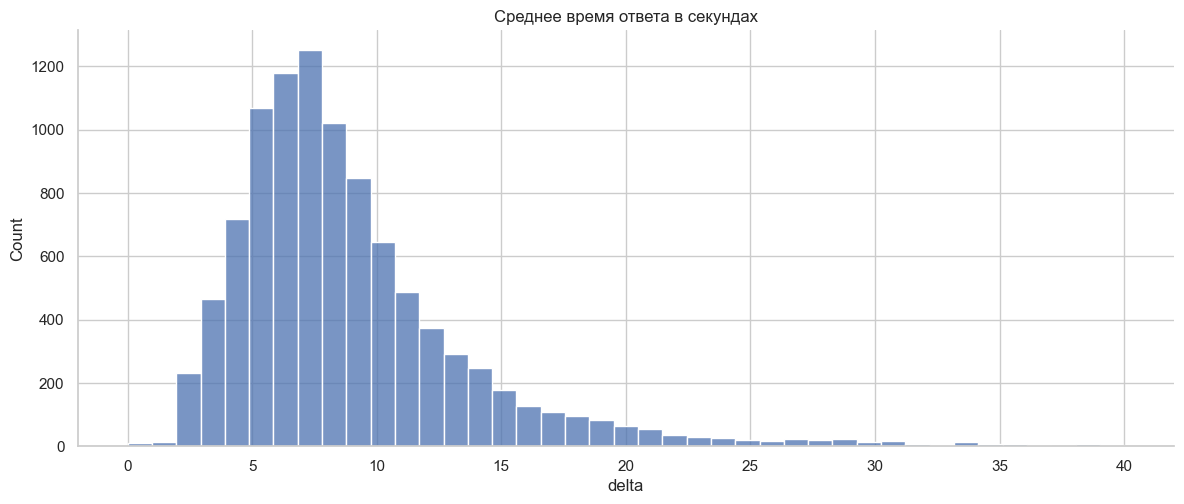

In [18]:
# распределение времени ответа в секундах
time_answer = tr37[tr37.delta <= 40].delta
sns.displot(time_answer, bins=41, aspect=12/5).set(title='Среднее время ответа в секундах');

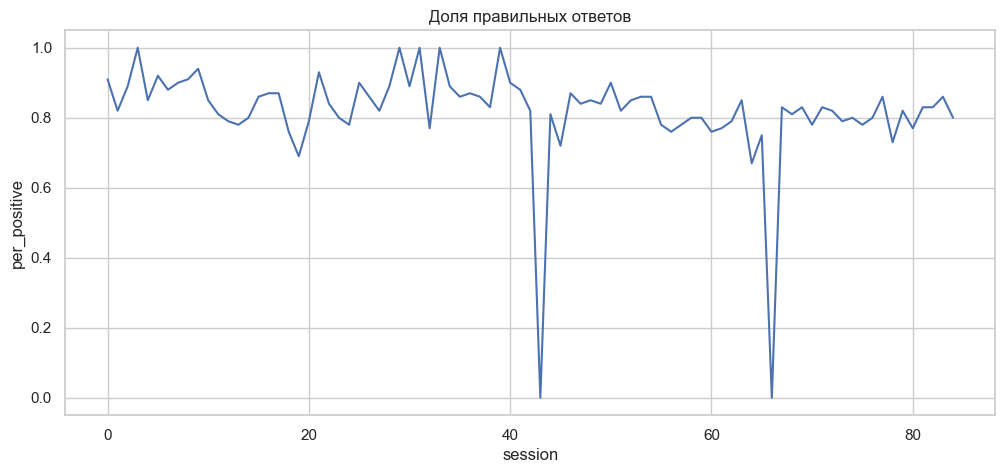

In [19]:
sns.lineplot(data=sess_info, x='session', y='per_positive').set(title='Доля правильных ответов');

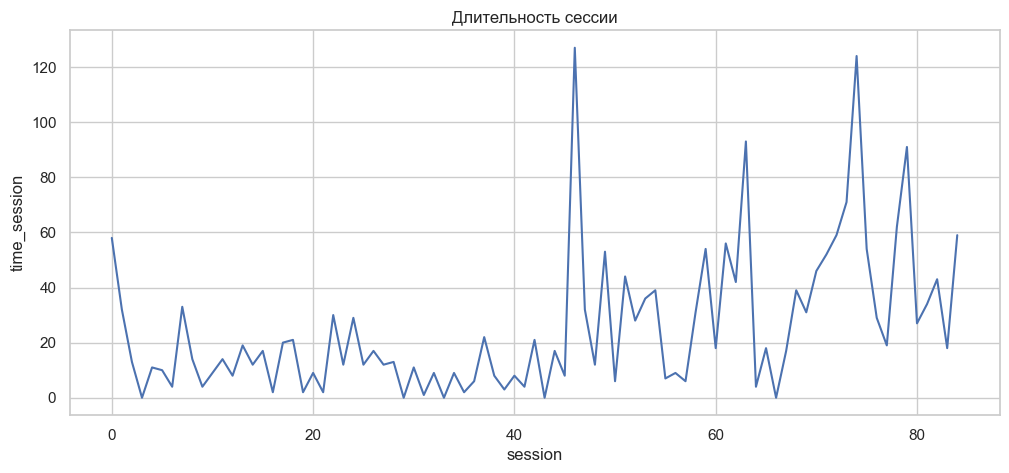

In [20]:
sns.lineplot(data=sess_info, x='session', y='time_session').set(title='Длительность сессии');

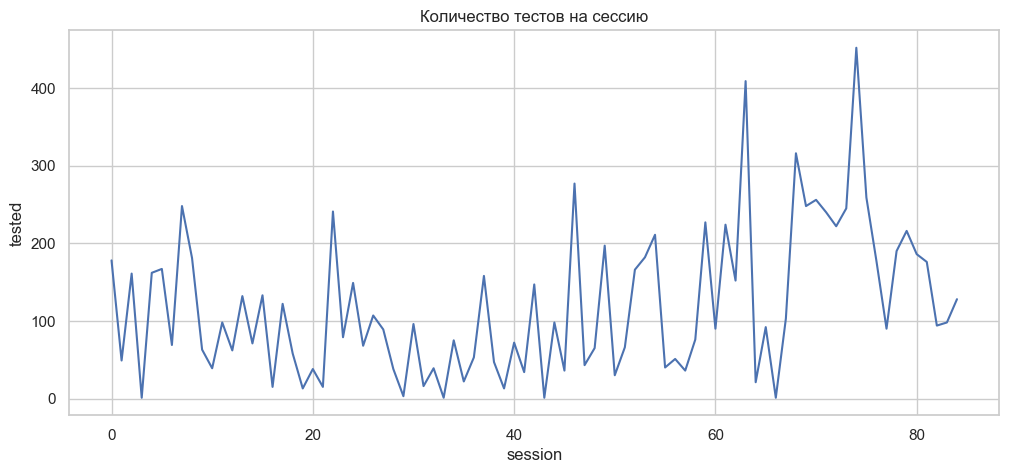

In [21]:
sns.lineplot(data=sess_info, x='session', y='tested').set(title='Количество тестов на сессию');

[Text(0.5, 1.0, 'Количество выученых слов')]

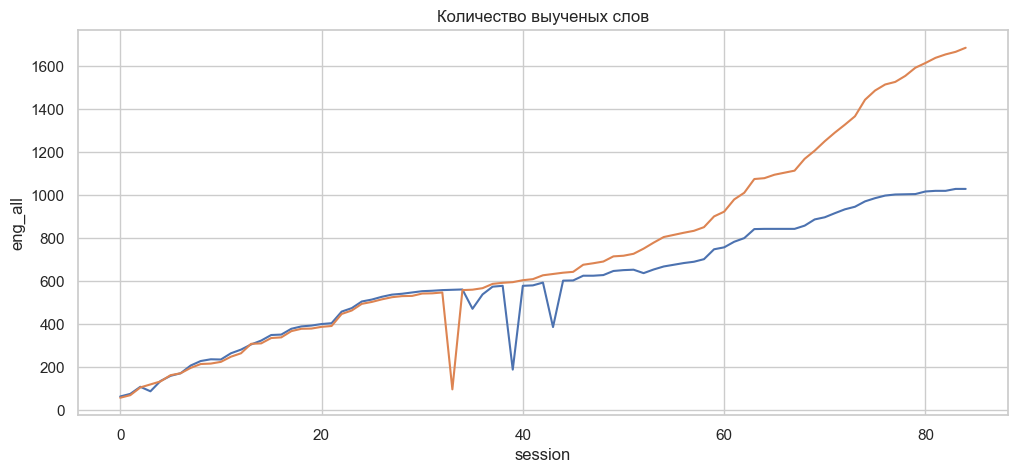

In [22]:
my_plot = sns.lineplot(data=sess_info, x='session', y='eng_all')
my_plot = sns.lineplot(data=sess_info, x='session', y='rus_all')
my_plot.set(title='Количество выученых слов')
#my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=50);

In [24]:
# количество сессий
ss = sess_info.session.count()
# уникальных дней
dt = sess_info.date.nunique()
# времени на занятия
ts = round(sess_info.time_session.sum() / 60, 1)
# проведено тестов
t = sess_info.tested.sum()
# доля правильных ответов
pp = round(sess_info.per_positive.mean(), 2)
# даты
dmn = sess_info.start.min().strftime('%Y-%m-%d')
dmx = sess_info.start.max().strftime('%Y-%m-%d')
# количество слов
e = sess_info.eng_all.max()
r = sess_info.rus_all.max()
# слов в минуту
wm = round(e / sess_info.time_session.sum(), 2)
# попыток на слово
tr = round(t / (e + r), 2)

print(f'с {dmn} по {dmx} \nза {dt} дней занятий, в течение {ts} часов')
print(f'где в среднем: {ts/dt*60} мин занятий в день, {round(ss / dt, 1)} подходов в день')
print(f'проведено за всё время {t} тестов, c долей правильных ответов {pp*100}%')
print(f'выучено {e} английских слов с {r} русскими значениями')
print(f'{wm} слов в минуту, {tr} повторов на одно заученное слово')

с 2022-06-01 по 2022-11-11 
за 45 дней занятий, в течение 36.0 часов
где в среднем: 48.0 мин занятий в день, 1.9 подходов в день
проведено за всё время 10109 тестов, c долей правильных ответов 82.0%
выучено 1030.0 английских слов с 1687.0 русскими значениями
0.48 слов в минуту, 3.72 повторов на одно заученное слово
